In [ ]:
# Install necessary libraries
!pip install nltk scikit-learn gensim transformers matplotlib

In [ ]:
# Import necessary libraries
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from sklearn.datasets import fetch_20newsgroups

# Load dataset
data = fetch_20newsgroups(subset='train', categories=['rec.sport.hockey', 'sci.space'], remove=('headers', 'footers', 'quotes'))
texts = data.data  # List of documents
labels = data.target  # Corresponding labels

print(f"Loaded {len(texts)} documents")

Loaded 1193 documents


In [ ]:
# Initialize CountVectorizer
vectorizer = CountVectorizer(max_features=1000)
X_bow = vectorizer.fit_transform(texts)

print("Shape of Bag of Words matrix:", X_bow.shape)
print("Example features:", vectorizer.get_feature_names_out()[:10])

Shape of Bag of Words matrix: (1193, 1000)
Example features: ['00' '000' '005' '01' '02' '03' '04' '05' '06' '10']


In [ ]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(texts)

print("Shape of TF-IDF matrix:", X_tfidf.shape)
print("Example features:", tfidf_vectorizer.get_feature_names_out()[:10])

Shape of TF-IDF matrix: (1193, 1000)
Example features: ['00' '000' '005' '01' '02' '03' '04' '05' '06' '10']


In [ ]:
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
# Tokenize texts
tokenized_texts = [word_tokenize(doc.lower()) for doc in texts]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=2, workers=4)

# Example word vector
print("Vector for 'hockey':", word2vec_model.wv['hockey'])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Vector for 'hockey': [-0.04047203  0.6327373   0.20149241 -0.00654742 -0.7881648  -1.0005474
 -0.08513998  0.9000167  -0.7076448   0.00623844 -0.8057377  -0.9430803
 -0.4781039   0.48399338 -0.20399307 -0.34509462  0.6422205   0.29294536
  0.6849122  -1.5168751   0.18788698 -0.06015939  0.64805096 -0.17856213
 -0.05895317  0.29278818 -1.3079802  -0.5038012  -0.27910042  0.3193437
  1.3532928   0.19187394 -0.57173026 -0.5233636  -0.14473732 -0.2246242
 -0.5109743   0.20959347  0.17218125 -1.1526935   0.24452949  0.5941334
 -0.4865345   0.35425273 -0.08607829 -0.7007792   0.28273717 -0.8317665
  1.0590489   0.68792266 -0.11666016  0.28025317  0.76696724  0.67562604
 -0.27378327  0.2885556   0.8217024  -0.40369564 -0.62285334  0.3154159
 -0.6405662  -0.38250828 -0.04604626  0.35528415  0.08557854  0.73685896
  0.40977624 -0.3181522  -1.0247384   0.8923494  -0.2675545  -0.58585334
 -0.5414737   0.05208972  0.2813892   0.248103    0.00374239 -0.50446653
 -0.01890057  0.3535532  -0.13419606 

In [ ]:
# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Generate BERT embeddings for a single text
sentence = "Hockey is an exciting sport."
inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=512)
outputs = model(**inputs)

# Get the [CLS] embedding
cls_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
print("Shape of CLS embedding:", cls_embedding.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Shape of CLS embedding: (1, 768)


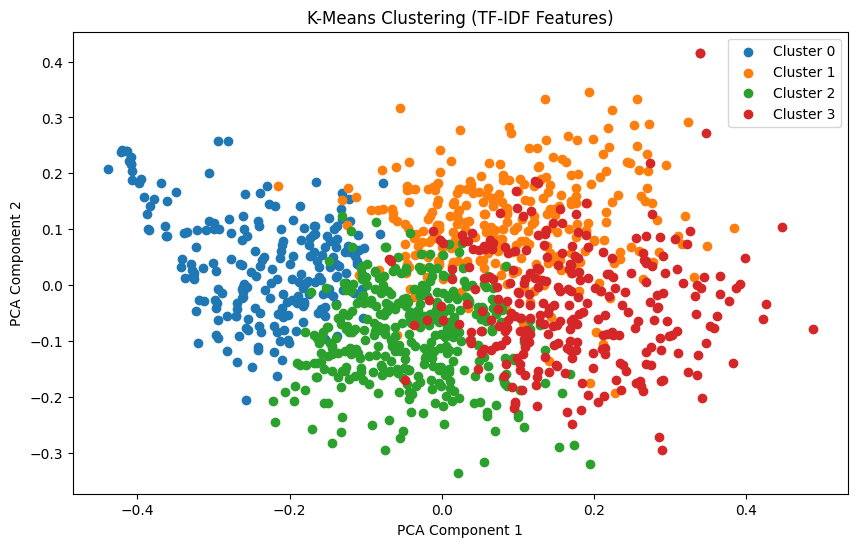

In [ ]:
# Apply K-Means clustering on TF-IDF features
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_tfidf)
labels = kmeans.labels_

# Visualize clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster_points = reduced_data[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

plt.title("K-Means Clustering (TF-IDF Features)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

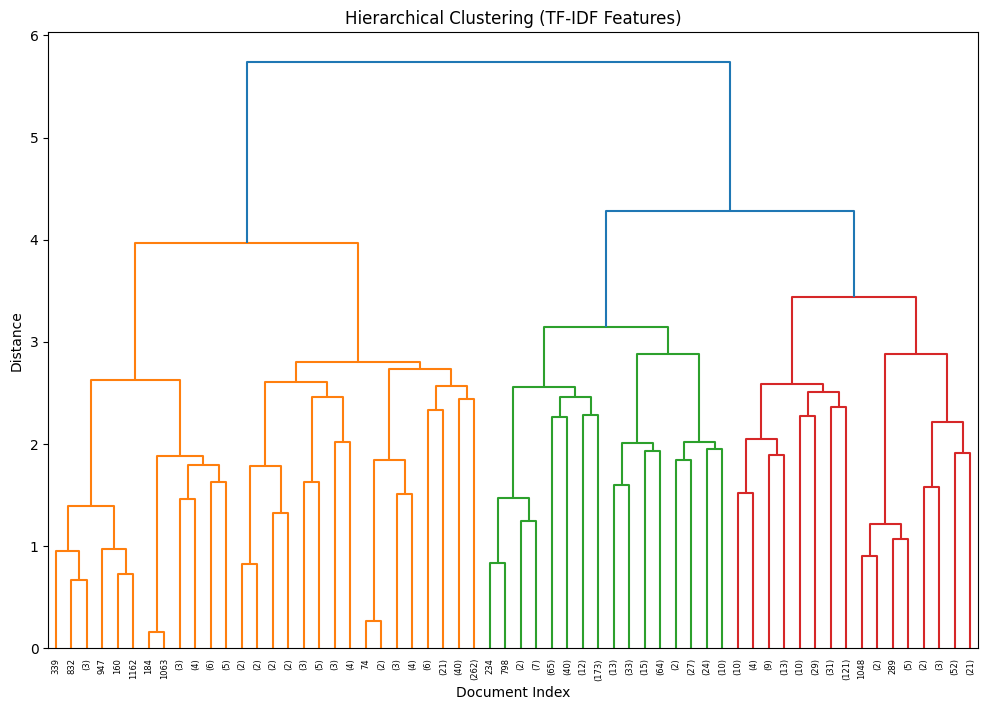

In [ ]:
# Perform hierarchical clustering
similarity_matrix = X_tfidf.toarray()
linkage_matrix = linkage(similarity_matrix, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5, orientation='top', leaf_rotation=90.)
plt.title("Hierarchical Clustering (TF-IDF Features)")
plt.xlabel("Document Index")
plt.ylabel("Distance")
plt.show()

Perform K-Means clustering with k=4 on the TF-IDF matrix. Use the silhouette_score metric to evaluate the clustering performance. Plot the silhouette scores for k values ranging from 2 to 10

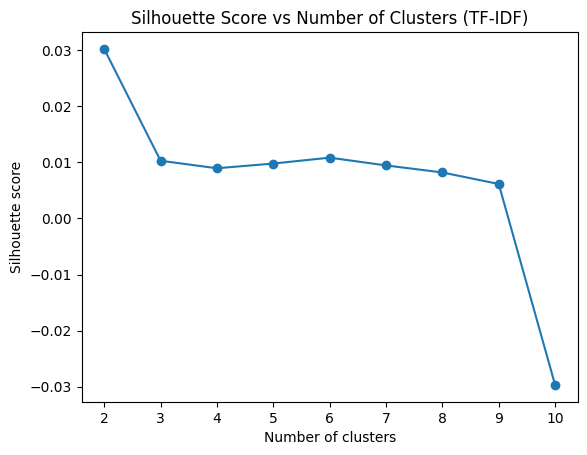

In [ ]:


silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_tfidf, labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters (TF-IDF)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

Task 2. Perform the following:Reduce the dimensionality of the TF-IDF matrix using Principal Component Analysis (PCA).Visualize the clusters in a 2D space.Find the optimal number of clusters using the Elbow method, and explain your findings.

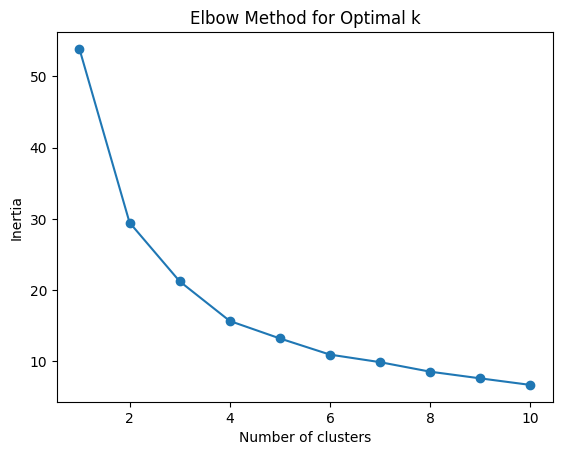

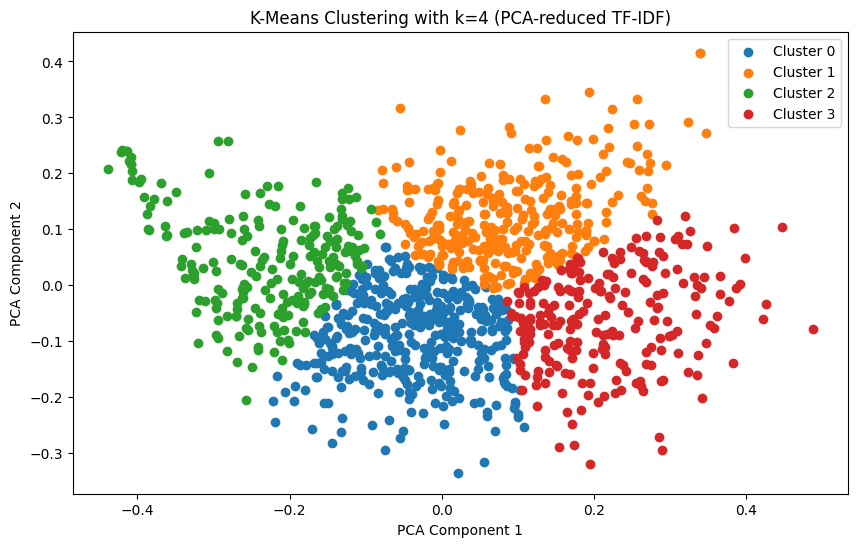

In [ ]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

# Reduce dimensionality with PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X_tfidf.toarray())

# Find optimal number of clusters using the Elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(reduced_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Explanation of the Elbow Method
# The elbow method looks for a point of diminishing returns on the inertia plot.
# The optimal number of clusters is where the rate of decrease in inertia slows down significantly.
# Visually inspect the plot for an "elbow" point.

# Apply K-means with the optimal k (e.g., based on the elbow method)
optimal_k = 4
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_optimal.fit(reduced_features)
labels = kmeans_optimal.labels_

# Visualize the clusters in 2D space
plt.figure(figsize=(10, 6))
for i in range(optimal_k):
    cluster_points = reduced_features[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

plt.title(f"K-Means Clustering with k={optimal_k} (PCA-reduced TF-IDF)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

Task 3. Compare the performance of k-Means and Hierarchical clustering for k = 2 to 10 using suitable evaluation metric. Plot the obtained result using suitable method.

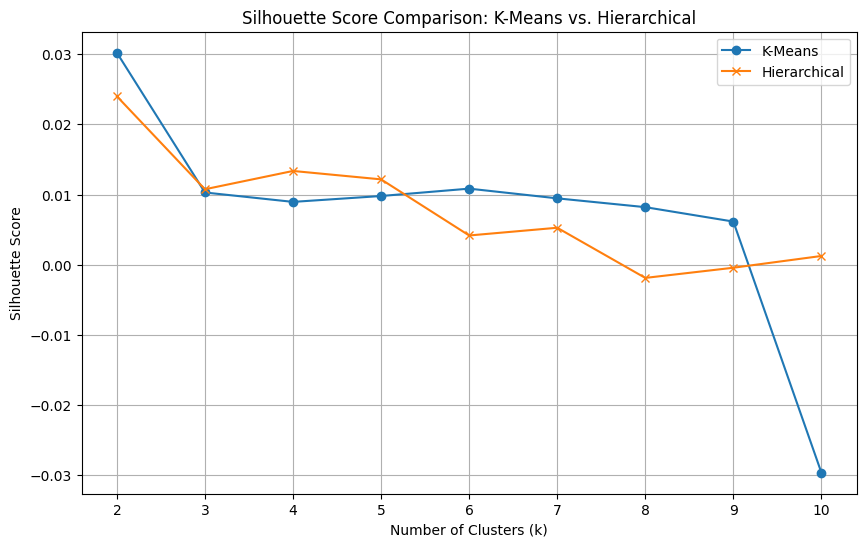

In [ ]:

from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

# Initialize lists to store silhouette scores
kmeans_silhouette_scores = []
hierarchical_silhouette_scores = []

# Iterate through different values of k
for k in range(2, 11):
    # K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    kmeans_labels = kmeans.labels_
    kmeans_silhouette_avg = silhouette_score(X_tfidf, kmeans_labels)
    kmeans_silhouette_scores.append(kmeans_silhouette_avg)

    # Hierarchical clustering
    hierarchical = AgglomerativeClustering(n_clusters=k)
    hierarchical_labels = hierarchical.fit_predict(X_tfidf.toarray())
    hierarchical_silhouette_avg = silhouette_score(X_tfidf, hierarchical_labels)
    hierarchical_silhouette_scores.append(hierarchical_silhouette_avg)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), kmeans_silhouette_scores, marker='o', label='K-Means')
plt.plot(range(2, 11), hierarchical_silhouette_scores, marker='x', label='Hierarchical')
plt.title('Silhouette Score Comparison: K-Means vs. Hierarchical')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

Task: 04

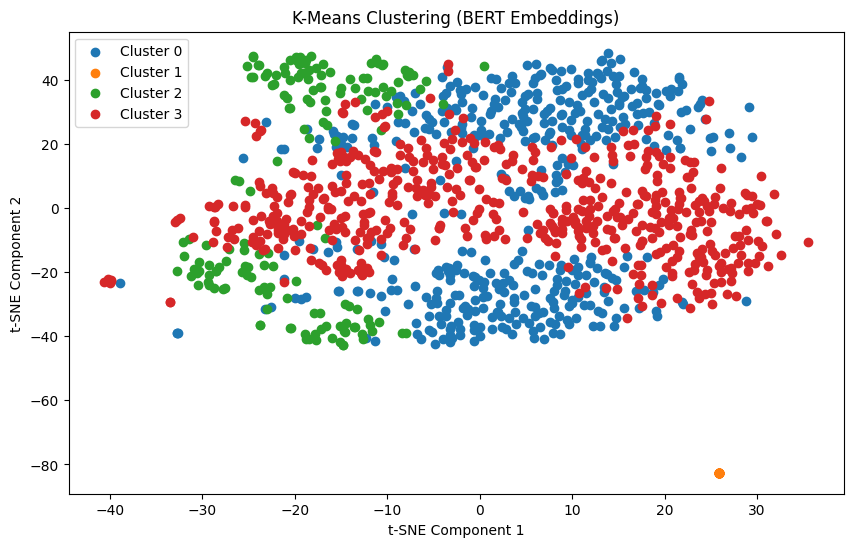

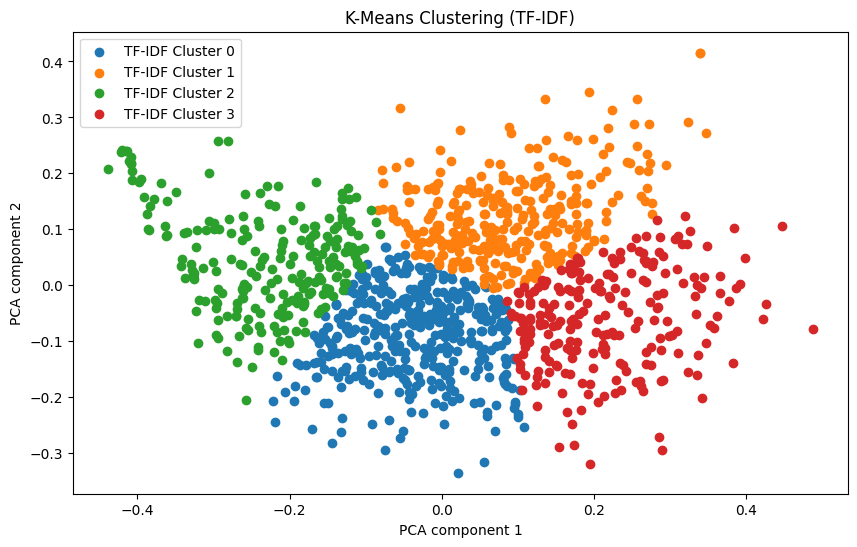

In [ ]:

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming 'model' and 'tokenizer' are already loaded from previous code
# ... (previous code to load BERT model and tokenizer) ...

# Generate BERT embeddings for all texts
all_embeddings = []
for text in texts:
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
    all_embeddings.append(cls_embedding.squeeze())  # Remove unnecessary dimensions

all_embeddings = np.array(all_embeddings)

# Perform K-Means clustering on BERT embeddings
kmeans = KMeans(n_clusters=4, random_state=42) # You can change the number of clusters
kmeans.fit(all_embeddings)
bert_labels = kmeans.labels_

# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(all_embeddings)


# Visualize the clusters
plt.figure(figsize=(10, 6))
for i in range(4): # Match the number of clusters from kmeans
    cluster_points = reduced_embeddings[bert_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
plt.title("K-Means Clustering (BERT Embeddings)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

# Comparison with TF-IDF results (assuming 'labels' from TF-IDF clustering is available)
# Visualize TF-IDF clusters (example using PCA, adjust as needed)
pca = PCA(n_components=2)
reduced_tfidf = pca.fit_transform(X_tfidf.toarray())
plt.figure(figsize=(10, 6))
for i in range(4): # Assuming 4 clusters for TF-IDF as well
  cluster_points = reduced_tfidf[labels == i]
  plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"TF-IDF Cluster {i}")
plt.title('K-Means Clustering (TF-IDF)')
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.legend()
plt.show()


